# tensorflow keras练习——RNN

In [21]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split

# 使能动态图机制
tf.enable_eager_execution()

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.layers import RepeatVector, TimeDistributed

## 二进制加法

参考：
[keras 使用RNN实现2进制加法](https://blog.csdn.net/u011311291/article/details/82153819)

### 数据生成

In [23]:
binary_dim = 8 # 二进制数长度
largest_number = pow(2,binary_dim)  
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
int2binary = {i: binary[i] for i in range(largest_number)}

In [24]:
x_train = []
y_train = []
for j in range(1000):
    # generate a simple addition problem (a + b = c)
    a_int = np.random.randint(largest_number / 2)
    b_int = np.random.randint(largest_number / 2)
    c_int = a_int + b_int    #真实和
    print('%d + %d = %d' % (a_int, b_int, c_int))
    
    a = list(int2binary[a_int])
    b = list(int2binary[b_int])
    c = list(int2binary[c_int])
    a.reverse(), b.reverse(), c.reverse()
    print('%s + %s = %s' % (a, b, c))

    tmp_x = np.hstack((np.array([a]).T, np.array([b]).T))
    tmp_y = np.array([c]).T
    #print(tmp_x)
    #print(tmp_y)

    x_train.append(tmp_x)
    y_train.append(tmp_y)

x_train = np.array(x_train)
y_train = np.array(y_train)

77 + 66 = 143
[1, 0, 1, 1, 0, 0, 1, 0] + [0, 1, 0, 0, 0, 0, 1, 0] = [1, 1, 1, 1, 0, 0, 0, 1]
115 + 61 = 176
[1, 1, 0, 0, 1, 1, 1, 0] + [1, 0, 1, 1, 1, 1, 0, 0] = [0, 0, 0, 0, 1, 1, 0, 1]
102 + 104 = 206
[0, 1, 1, 0, 0, 1, 1, 0] + [0, 0, 0, 1, 0, 1, 1, 0] = [0, 1, 1, 1, 0, 0, 1, 1]
95 + 30 = 125
[1, 1, 1, 1, 1, 0, 1, 0] + [0, 1, 1, 1, 1, 0, 0, 0] = [1, 0, 1, 1, 1, 1, 1, 0]
67 + 64 = 131
[1, 1, 0, 0, 0, 0, 1, 0] + [0, 0, 0, 0, 0, 0, 1, 0] = [1, 1, 0, 0, 0, 0, 0, 1]
97 + 34 = 131
[1, 0, 0, 0, 0, 1, 1, 0] + [0, 1, 0, 0, 0, 1, 0, 0] = [1, 1, 0, 0, 0, 0, 0, 1]
123 + 47 = 170
[1, 1, 0, 1, 1, 1, 1, 0] + [1, 1, 1, 1, 0, 1, 0, 0] = [0, 1, 0, 1, 0, 1, 0, 1]
90 + 95 = 185
[0, 1, 0, 1, 1, 0, 1, 0] + [1, 1, 1, 1, 1, 0, 1, 0] = [1, 0, 0, 1, 1, 1, 0, 1]
18 + 71 = 89
[0, 1, 0, 0, 1, 0, 0, 0] + [1, 1, 1, 0, 0, 0, 1, 0] = [1, 0, 0, 1, 1, 0, 1, 0]
65 + 81 = 146
[1, 0, 0, 0, 0, 0, 1, 0] + [1, 0, 0, 0, 1, 0, 1, 0] = [0, 1, 0, 0, 1, 0, 0, 1]
72 + 110 = 182
[0, 0, 0, 1, 0, 0, 1, 0] + [0, 1, 1, 1, 0, 1, 1, 0] 

5 + 99 = 104
[1, 0, 1, 0, 0, 0, 0, 0] + [1, 1, 0, 0, 0, 1, 1, 0] = [0, 0, 0, 1, 0, 1, 1, 0]
21 + 111 = 132
[1, 0, 1, 0, 1, 0, 0, 0] + [1, 1, 1, 1, 0, 1, 1, 0] = [0, 0, 1, 0, 0, 0, 0, 1]
67 + 106 = 173
[1, 1, 0, 0, 0, 0, 1, 0] + [0, 1, 0, 1, 0, 1, 1, 0] = [1, 0, 1, 1, 0, 1, 0, 1]
21 + 120 = 141
[1, 0, 1, 0, 1, 0, 0, 0] + [0, 0, 0, 1, 1, 1, 1, 0] = [1, 0, 1, 1, 0, 0, 0, 1]
22 + 56 = 78
[0, 1, 1, 0, 1, 0, 0, 0] + [0, 0, 0, 1, 1, 1, 0, 0] = [0, 1, 1, 1, 0, 0, 1, 0]
5 + 27 = 32
[1, 0, 1, 0, 0, 0, 0, 0] + [1, 1, 0, 1, 1, 0, 0, 0] = [0, 0, 0, 0, 0, 1, 0, 0]
49 + 91 = 140
[1, 0, 0, 0, 1, 1, 0, 0] + [1, 1, 0, 1, 1, 0, 1, 0] = [0, 0, 1, 1, 0, 0, 0, 1]
67 + 84 = 151
[1, 1, 0, 0, 0, 0, 1, 0] + [0, 0, 1, 0, 1, 0, 1, 0] = [1, 1, 1, 0, 1, 0, 0, 1]
87 + 18 = 105
[1, 1, 1, 0, 1, 0, 1, 0] + [0, 1, 0, 0, 1, 0, 0, 0] = [1, 0, 0, 1, 0, 1, 1, 0]
43 + 124 = 167
[1, 1, 0, 1, 0, 1, 0, 0] + [0, 0, 1, 1, 1, 1, 1, 0] = [1, 1, 1, 0, 0, 1, 0, 1]
96 + 71 = 167
[0, 0, 0, 0, 0, 1, 1, 0] + [1, 1, 1, 0, 0, 0, 1, 0] = [1

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)
print(x_train.shape, y_train.shape)
print(x_test.shape, x_test.shape)

(700, 8, 2) (700, 8, 1)
(300, 8, 2) (300, 8, 2)


### 模型构建

![简单RNN结构](http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg)

In [26]:
model = Sequential()
model.add(SimpleRNN(16,
                    input_shape=(8, 2),
                    return_sequences=True,
                    return_state=False,
                    activation='tanh'))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

In [27]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 8, 16)             304       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 8, 1)              17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


### 训练

In [28]:
history = model.fit(x_train,
          y_train,
          batch_size=32,
          epochs=100,
          validation_data=(x_test, y_test)) 

Train on 700 samples, validate on 300 samples
Epoch 1/100
700/700 [==============================] - 1s 2ms/sample - loss: 0.6956 - acc: 0.5370 - val_loss: 0.6935 - val_acc: 0.5500
Epoch 2/100
700/700 [==============================] - 0s 144us/sample - loss: 0.6897 - acc: 0.5593 - val_loss: 0.6894 - val_acc: 0.5396
Epoch 3/100
700/700 [==============================] - 0s 142us/sample - loss: 0.6871 - acc: 0.5384 - val_loss: 0.6877 - val_acc: 0.5483
Epoch 4/100
700/700 [==============================] - 0s 141us/sample - loss: 0.6855 - acc: 0.5545 - val_loss: 0.6851 - val_acc: 0.5608
Epoch 5/100
700/700 [==============================] - 0s 145us/sample - loss: 0.6839 - acc: 0.5759 - val_loss: 0.6841 - val_acc: 0.6000
Epoch 6/100
700/700 [==============================] - 0s 139us/sample - loss: 0.6824 - acc: 0.5818 - val_loss: 0.6835 - val_acc: 0.5821
Epoch 7/100
700/700 [==============================] - 0s 141us/sample - loss: 0.6808 - acc: 0.5875 - val_loss: 0.6810 - val_acc: 0.58

700/700 [==============================] - 0s 141us/sample - loss: 0.3446 - acc: 0.9493 - val_loss: 0.3447 - val_acc: 0.9588
Epoch 61/100
700/700 [==============================] - 0s 140us/sample - loss: 0.3344 - acc: 0.9648 - val_loss: 0.3339 - val_acc: 0.9617
Epoch 62/100
700/700 [==============================] - 0s 141us/sample - loss: 0.3246 - acc: 0.9677 - val_loss: 0.3245 - val_acc: 0.9608
Epoch 63/100
700/700 [==============================] - 0s 143us/sample - loss: 0.3146 - acc: 0.9721 - val_loss: 0.3135 - val_acc: 0.9708
Epoch 64/100
700/700 [==============================] - 0s 139us/sample - loss: 0.3046 - acc: 0.9752 - val_loss: 0.3038 - val_acc: 0.9800
Epoch 65/100
700/700 [==============================] - 0s 142us/sample - loss: 0.2951 - acc: 0.9784 - val_loss: 0.2938 - val_acc: 0.9771
Epoch 66/100
700/700 [==============================] - 0s 142us/sample - loss: 0.2858 - acc: 0.9827 - val_loss: 0.2845 - val_acc: 0.9817
Epoch 67/100
700/700 [=========================

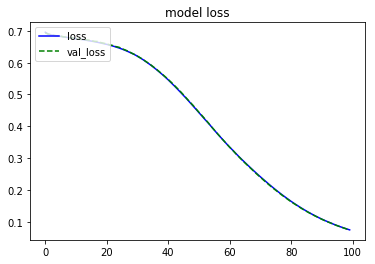

In [29]:
plt.plot(history.history['loss'], c='b')
plt.plot(history.history['val_loss'], linestyle="--", c='g')
plt.title("model loss")
plt.legend(["loss", "val_loss"], loc="upper left")
plt.show()

### 结果评估

In [30]:
score = model.evaluate(x_test, y_test)
print("loss:%.4f" % score[0])
print("acc:%.4f" % score[1])

300/300 [==============================] - 0s 57us/sample - loss: 0.0744 - acc: 1.0000
loss:0.0744
acc:1.0000


In [31]:
a = [1, 1, 0, 1, 0, 0, 1, 0]
b = [1, 0, 0, 0, 1, 1, 0, 0]
predict = model.predict(np.array([a, b]).T.reshape(-1, 8, 2))
predict = predict.flatten()
predict_val = [1 if predict[i] >= 0.5 else 0 for i in range(predict.shape[0])]
print('%s + %s = %s' % (a, b, predict_val))

[1, 1, 0, 1, 0, 0, 1, 0] + [1, 0, 0, 0, 1, 1, 0, 0] = [0, 0, 1, 1, 1, 1, 1, 0]


## 十进制整数加法

简述：
<p>用RNN拟合整数的加法运算，其中被加数和加数在区间限制在[0,1000)内。

<p>输入: "535+61"
<p>输出: "596"

参考：
- [用RNN拟合加法运算](https://blog.csdn.net/whai362/article/details/52523439)
- [LSTM的架构及公式](https://blog.csdn.net/Alexbyy/article/details/86584322)
- [An implementation of sequence to sequence learning for performing addition](https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py)

### 数据生成

In [32]:
class CharacterTable(object):
    '''在指定的字符集上对字符串进行one-hot编码解码等操作
    '''
    def __init__(self, chars):
        '''初始化字符集
        '''
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, s, num_rows):
        '''将指定的字符串编码成One-hot矩阵
        '''
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(s):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        '''将one-hot矩阵解码成字符串
        '''
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[c] for c in x)

In [33]:
# 模型和训练参数
DIGITS = 3
TRAINING_SIZE = 50000
# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
ctable = CharacterTable(chars)

# Input may optionally be reversed, shown to increase performance in many tasks
# Theoretically it introduces shorter term dependencies between source and target
# Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
# space used for padding.)
REVERSE = True

pd.set_option('display.max_rows', 20)

In [34]:
questions = []
expected = []
seen = set()

print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))

    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
        
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 50000


In [35]:
print(pd.DataFrame({'questions': questions, 'expected': expected}))

      questions expected
0          83+6     44  
1        27+066     732 
2        228+32     845 
3           4+2     6   
4         8+072     278 
5       846+405     1152
6         58+17     156 
7        783+68     473 
8        35+927     782 
9          12+9     30  
...         ...      ...
49990   847+367     1511
49991    124+66     487 
49992   244+693     838 
49993    87+184     559 
49994    784+34     530 
49995    31+481     197 
49996    51+109     916 
49997    15+364     514 
49998    292+77     369 
49999   752+712     474 

[50000 rows x 2 columns]


In [36]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# shuffle x and y
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

Vectorization...


In [37]:
# 将数据集分割为训练集和验证集

split_at = len(x) - 2 * len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Training Data:
(40000, 7, 12)
(40000, 4, 12)
Validation Data:
(10000, 7, 12)
(10000, 4, 12)


In [38]:
print(pd.DataFrame({'questions': [ctable.decode(x_train[i]) for i in range(10)],
                    'expected': [ctable.decode(y_train[i]) for i in range(10)]}))

  questions expected
0     41+15     65  
1    36+202     265 
2   629+631     1062
3     715+8     525 
4   657+188     1637
5    206+43     636 
6     342+8     251 
7     4+267     766 
8    22+865     590 
9    55+254     507 


### 模型构建

![](https://img-blog.csdnimg.cn/2019012210501779.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L0FsZXhieXk=,size_16,color_FFFFFF,t_70)
![](https://img-blog.csdnimg.cn/20190122110244661.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L0FsZXhieXk=,size_16,color_FFFFFF,t_70)

In [39]:
# Try replacing GRU, or SimpleRNN.
RNN = LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(TimeDistributed(Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


### 训练

In [40]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=50,
                    validation_data=(x_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 17s 437us/sample - loss: 1.8972 - acc: 0.3199 - val_loss: 1.7917 - val_acc: 0.3417
Epoch 2/50
40000/40000 [==============================] - 14s 343us/sample - loss: 1.7471 - acc: 0.3553 - val_loss: 1.6802 - val_acc: 0.3800
Epoch 3/50
40000/40000 [==============================] - 14s 356us/sample - loss: 1.6309 - acc: 0.3926 - val_loss: 1.5614 - val_acc: 0.4118
Epoch 4/50
40000/40000 [==============================] - 14s 343us/sample - loss: 1.4875 - acc: 0.4419 - val_loss: 1.4049 - val_acc: 0.4746
Epoch 5/50
40000/40000 [==============================] - 14s 342us/sample - loss: 1.3390 - acc: 0.5008 - val_loss: 1.2731 - val_acc: 0.5264
Epoch 6/50
40000/40000 [==============================] - 14s 344us/sample - loss: 1.2189 - acc: 0.5487 - val_loss: 1.1556 - val_acc: 0.5720
Epoch 7/50
40000/40000 [==============================] - 14s 343us/sample - loss: 1.0947 - acc: 0.5999 

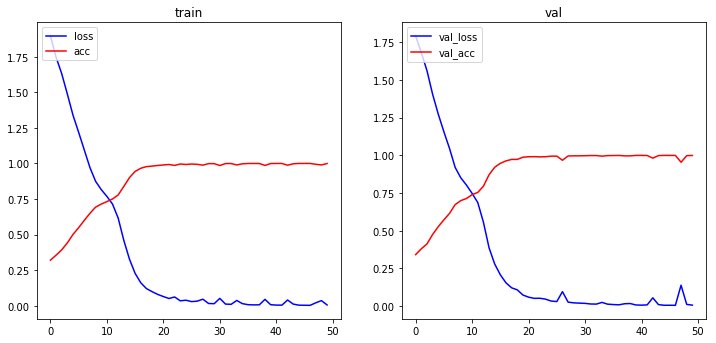

In [41]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(2, 2, 1)
ax.plot(history.history['loss'], c='b')
ax.plot(history.history['acc'], c='r')
ax.set_title("train")
ax.legend(["loss", "acc"], loc="upper left")

ax = fig.add_subplot(2, 2, 2)
ax.plot(history.history['val_loss'], c='b')
ax.plot(history.history['val_acc'], c='r')
ax.set_title("val")
ax.legend(["val_loss", "val_acc"], loc="upper left")

fig.show()

### 结果评估

In [45]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'
    
# Select 10 samples from the validation set at random so we can visualize errors.
for i in range(10):
    ind = np.random.randint(0, len(x_val))
    rowx, rowy = x_val[ind], y_val[ind]
    rowx, rowy = rowx[np.newaxis, :], rowy[np.newaxis, :]
    
    preds = model.predict_classes(rowx)
    q = ctable.decode(rowx[0])
    ans = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    correct = colors.ok + '☑' if ans == guess else colors.fail + '☒'
    q = q[::-1] if REVERSE else q
    print('%s Q %s A %s G %s %s' % (correct, q, ans, guess, colors.close))

☑ Q 42+291  A 333  G 333  
☑ Q 249+75  A 324  G 324  
☑ Q 75+319  A 394  G 394  
☑ Q 542+40  A 582  G 582  
☑ Q 44+80   A 124  G 124  
☑ Q 347+593 A 940  G 940  
☑ Q 130+8   A 138  G 138  
☑ Q 24+86   A 110  G 110  
☑ Q 410+42  A 452  G 452  
☑ Q 444+115 A 559  G 559  
